## 카드 뉴스 생성


추출된 키워드를 바탕으로 이미지 생성 (Karlo API 이용) -> 이미지 위에 말투변환된 요약문 올리기

### 라이브러리 불러오기

In [1]:
!pip install PyKakao --upgrade

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
import warnings
warnings.filterwarnings('ignore')

## Karlo

In [4]:
from PyKakao import Karlo
api = Karlo(service_key = "f4772cdef6aa15d8561268d8397d6189")

## 데이터 불러오기

In [7]:
import pandas as pd
df = pd.read_csv('summaryNspeechtrans.csv', encoding = 'utf-8')

In [8]:
df

,transfer
0,평소에 먹는 약이 있다면? 이 음식을 주의하세요!
1,"음식도 가려 먹어야 약의 효과를 확인할 수 있어요. 알레르기 약, 고혈압 약, 고지..."
2,아세트아미노펜은 간 손상과 위장관 출혈을 일으킬 수 있으므로 꼭 피하는 것이 좋습니다.
3,"카페인을 만나면 기관지 천식이나 만성 기관지염이 생길 수 있으므로, 알부테롤과 클렌..."
4,펙소페나딘'은 알레르기 약 성분의 흡수를 방해하여 알레르기 약의 흡수를 저해할 수 ...
5,"우유, 요거트 등 유제품을 섭취한 후에는 1시간 후에 약을 복용해야 하며, 베타차단..."
6,"와파린은 혈전 발생 위험이 높은 사람에게 혈관이 막히는 것을 방지하는 항응고제이며,..."
7,"자몽 주스에는 시금치, 상추, 양배추, 브로콜리와 같은 녹색 채소나 양배추, 그리고..."


In [48]:
text = ""
for i in range(len(df['transfer'])):
  text += df['transfer'][i] + "\n"

In [49]:
text

"평소에 먹는 약이 있다면? 이 음식을 주의하세요!\n음식도 가려 먹어야 약의 효과를 확인할 수 있어요. 알레르기 약, 고혈압 약, 고지혈증 치료제 등은 약 효과를 떨어뜨리니까요.\n아세트아미노펜은 간 손상과 위장관 출혈을 일으킬 수 있으므로 꼭 피하는 것이 좋습니다.\n카페인을 만나면 기관지 천식이나 만성 기관지염이 생길 수 있으므로, 알부테롤과 클렌부테롤 성분이 결합된 알부기억제제를 피하는 것이 좋습니다.\n펙소페나딘'은 알레르기 약 성분의 흡수를 방해하여 알레르기 약의 흡수를 저해할 수 있습니다.\n우유, 요거트 등 유제품을 섭취한 후에는 1시간 후에 약을 복용해야 하며, 베타차단제는 심장 박동 수를 감소시키는 약이므로 붉은 육류를 섭취하지 않는 것이 좋습니다.\n와파린은 혈전 발생 위험이 높은 사람에게 혈관이 막히는 것을 방지하는 항응고제이며, 특히 고혈압 환자에게는 특별한 주의가 필요합니다.\n자몽 주스에는 시금치, 상추, 양배추, 브로콜리와 같은 녹색 채소나 양배추, 그리고 브로콜리가 함유되어 있으며, 72시간 동안 섭취하면 약에 영향을 미칠 수 있으므로, 72시간 간격을 두고 섭취하시는 것을 권장합니다.\n"

## 카드뉴스 생성

In [173]:
from PIL import Image, ImageDraw, ImageFont

def makeCardNews(text, keywords):
    kb_logo = Image.open('KB_logo.png')
    kb_golden = Image.open('KB골든라이프X.png')
    kb_logo = kb_logo.resize((int(kb_logo.size[0] * 0.4), int(kb_logo.size[1] * 0.4))).convert("RGBA")
    kb_golden = kb_golden.resize((int(kb_golden.size[0]*1.5), int(kb_golden.size[1]*1.5))).convert("RGBA")
    texts = text.split('\n')
    texts[len(texts)-1] = ('자세한 사항은 KB골든라이프X에서 확인할 수 있습니다. KB골드라이프X에서 자산관리, 라이프, 헬스케어 등 실생활에 유용한 정보를 알아보세요!')

    for i in range(len(texts)):
        if i % 3 == 0:
            img_dict = api.text_to_image(keywords, 3)
        img_str = img_dict.get("images")[i % 3].get('image')
        img = api.string_to_image(base64_string=img_str, mode='RGBA')
        image_width, image_height = img.size
        img.putalpha(110)
        draw = ImageDraw.Draw(img)

        # KB 로고
        img.paste(kb_logo, (703, 0), kb_logo)

        # 투명한 흰 색 배경 그리기
        if i == 0  or i == len(texts)-1:
          overlay = Image.new("RGBA", (int(image_width * 0.8), int(image_height * 0.8)), (255, 255, 255, 200))
        else:
          overlay = Image.new("RGBA", (int(image_width * 0.8), int(image_height * 0.8)), (0, 0, 0, 50))

        # 이미지 겹치기
        merged_image = Image.new("RGBA", img.size)
        merged_image.paste(img, (0, 0))
        merged_image.paste(overlay, ((image_width - overlay.width) // 2, (image_height - overlay.height) // 2), overlay)

        # 텍스트 배치
        if i == 0:
            font = ImageFont.truetype("NotoSansKR-Bold.otf", size=70)
        else:
            font = ImageFont.truetype("NotoSansKR-Regular.otf", size=55)

        words = texts[i].split()

        lines = []
        line = ""
        for word in words:
            if font.getsize(line + ' ' + word)[0] <= image_width * 0.8:
                line += ' ' + word
            else:
                lines.append(line)
                line = word
        lines.append(line)

        draw = ImageDraw.Draw(merged_image)

        if i < len(texts)-1:
          text_y = (image_height - font.getsize(lines[0])[1] * len(lines)) // 2
        else:
          text_y = (image_height - font.getsize(lines[0])[1] * len(lines)) // 3
        for line in lines:
            text_width, text_height = font.getsize(line)
            text_x = (image_width - text_width) // 2

            draw.text((text_x, text_y), line, fill=(0, 0, 0), font=font)
            text_y += text_height
        if i == len(texts)-1:
          golden_x = (image_width - kb_golden.size[0]) // 2
          golden_y = text_y + ((overlay.height + (image_height - overlay.height) // 2) - text_y - kb_golden.height) // 2
          merged_image.paste(kb_golden, (golden_x,  golden_y), kb_golden)

        # 이미지 저장하기
        merged_image.save(f"./cardNews{i + 1}.png")
        plt.imshow(merged_image)
        plt.axis('off')
        plt.show()

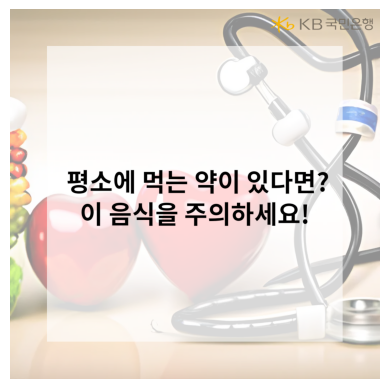

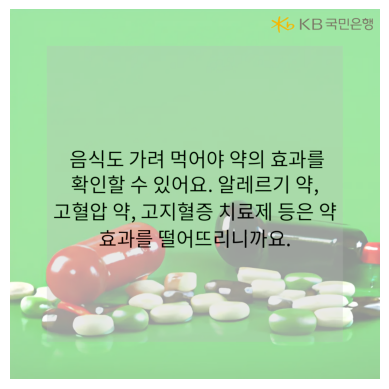

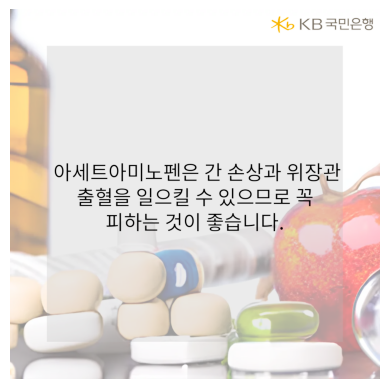

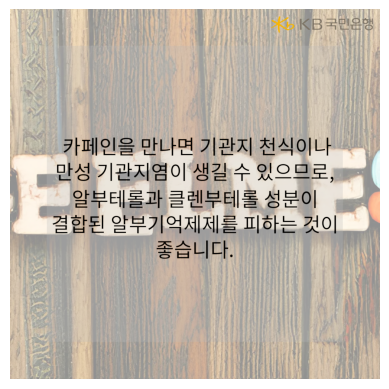

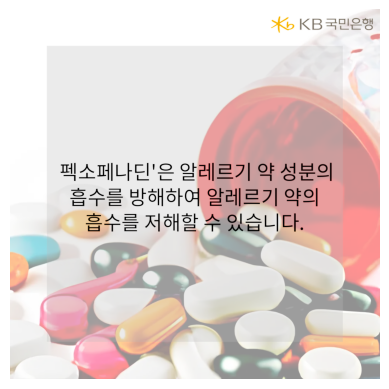

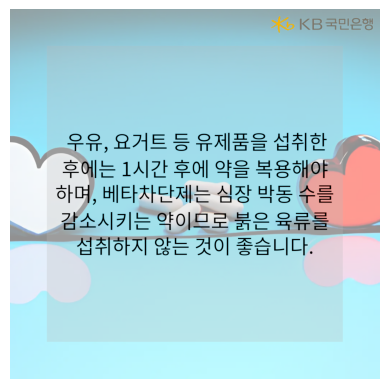

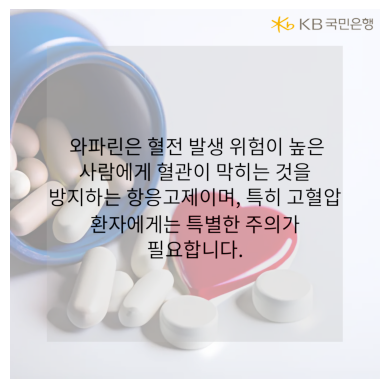

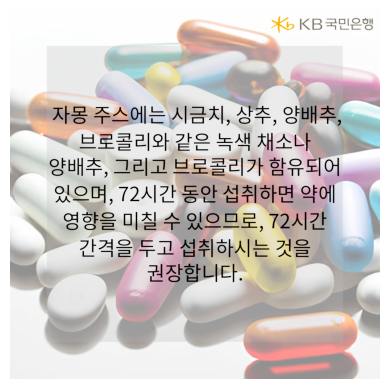

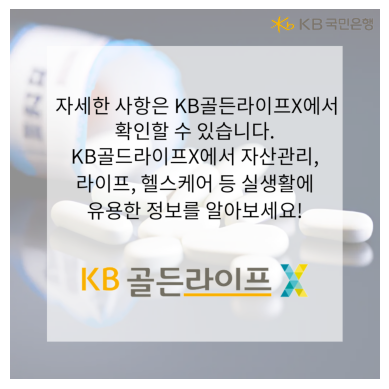

In [174]:
makeCardNews(text, "health, medicine")